# $\textbf{US Macro Data Forecasting Report}$

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/15eRh90lvpynFFSyrKMkzfIGOZeIH9Rg4"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/15eRh90lvpynFFSyrKMkzfIGOZeIH9Rg4"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/Waerden001/USMacro/blob/master/USMacro_Report_Full.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://github.com/Waerden001/USMacro/blob/master/USMacro_Report_Full.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This is a report on analyzing and forecasting the US macro data using $\textbf{Recurrent Neural Networks (RNNs)}$, $\textbf{Convolutional Neural Network (CNNs)}$ and $\textbf{Generative Adversarial Network (GAN)}$. The global structure of the report is:

$\textbf{Part I. Statistical analysis}$
  - Basic manipulation
  - Correlation analysis
  - Time series analysis with ```ARIMA```

$\textbf{Part II. Deep learning models}$
  
  - Basic model: single-step, single-feature forecasting with LSTM
  - Generalized model: multi-step, multi-feature forcasting with LSTM
  - Advanced model: Generative Adversarial Network (GAN) with RNN and CNN. 

$\textbf{Part III. Conclusions and Next steps}$
  - Conclusions
  - Next steps

## $\textbf{Introduction}$

### 1. <a>The Notebook</a>

Follow the notebook, we can recreate all the results, notice that 
- Upload the ```USMacroData.xls``` file to the root folder on google colab.
- To navigate better, use the table of contents bottom on the upper-left sidebar. 
- $\textbf{For clarity, all code cells are hidden, double click on the cell to get the code}$. 
- Change the parameters as indicated in the comments to create more custom outputs.  
- All source code can also be found in the project file folder


### 2. The US Macro dataset

This report uses a <a>US Macro Dataset</a> provided by the <a>ADP</a>.

Before analyzing the data with codes, we have the following observations. 

- This dataset contains $\textbf{6}$ different features (the $\textbf{Inflation, Wage, Unemployment, Consumption, Investment}$ and the $\textbf{InterstRate}$) about the macro economy of the US.
- Data were collected every $\textbf{1}$ month, beginning in $\textbf{1965-01-01 to 2015-12-01}$. 
- In total, we have $\textbf{612 rows (month)}$ and $\textbf{6 columns (features)}$.

## $\textbf{Part I.1 Basic manipulation}$

### Code and examples

In [0]:
#@title ```basic.py```

#import numpy, pandas and matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


#Basic checks: find null values and fill, set index, etc.

def basic_check(df, index_name = "Month"):
  """Find the null values and set index of a given DataFrame.
  :param: df, pd.DataFrame, the data, e.g. df = pd.read_excel("USMacroData.xls", "All")
  :param: index_name, str, name of the index, must be one of the column names, e.g. index_name ="Month"
  :rtype: pd.DataFrame
  """
  df = df.sort_values(index_name)
  df.set_index(index_name, inplace=True)

  #check for null entries
  print("Null values summary:\n")
  print(df.isnull().sum())

  return df

def plot_column(df, feature):
    """Plot the resampled column of df, e.g. plot_column(df, "Inflation") plots the "Inflation" column
    
    :param: df, pandas.DataFrame, the data, e.g. df = pd.read_excel("USMacroData", "All")
    :param: feature, str, name of column to be plotted. 
    """
    y = df[feature].resample('MS').mean()
    y.plot(figsize=(18, 8))
    plt.xlabel('Date')
    plt.ylabel(feature)
    plt.show()

In [0]:
#@title read the file and show the head

us_macro = pd.read_excel("USMacroData.xls", "All")
us_macro.head()

,Month,Inflation,Wage,Unemployment,Consumption,Investment,InterestRate
0,1965-01-01,1.557632,3.200000,4.9,6.972061,12.3,3.90
1,1965-02-01,1.557632,3.600000,5.1,7.811330,13.2,3.98
2,1965-03-01,1.242236,4.000000,4.7,7.828032,18.7,4.04
3,1965-04-01,1.552795,3.585657,4.8,8.477938,9.8,4.09
4,1965-05-01,1.552795,3.968254,4.6,7.139364,10.2,4.10


In [0]:
#@title Basic checks: find null values and fill, set index, etc.

us_macro.isnull().sum()
df = basic_check(us_macro)
df.head()

Null values summary:

Inflation       0
Wage            0
Unemployment    0
Consumption     0
Investment      0
InterestRate    0
dtype: int64


,Inflation,Wage,Unemployment,Consumption,Investment,InterestRate
Month,,,,,,
1965-01-01,1.557632,3.200000,4.9,6.972061,12.3,3.90
1965-02-01,1.557632,3.600000,5.1,7.811330,13.2,3.98
1965-03-01,1.242236,4.000000,4.7,7.828032,18.7,4.04
1965-04-01,1.552795,3.585657,4.8,8.477938,9.8,4.09
1965-05-01,1.552795,3.968254,4.6,7.139364,10.2,4.10


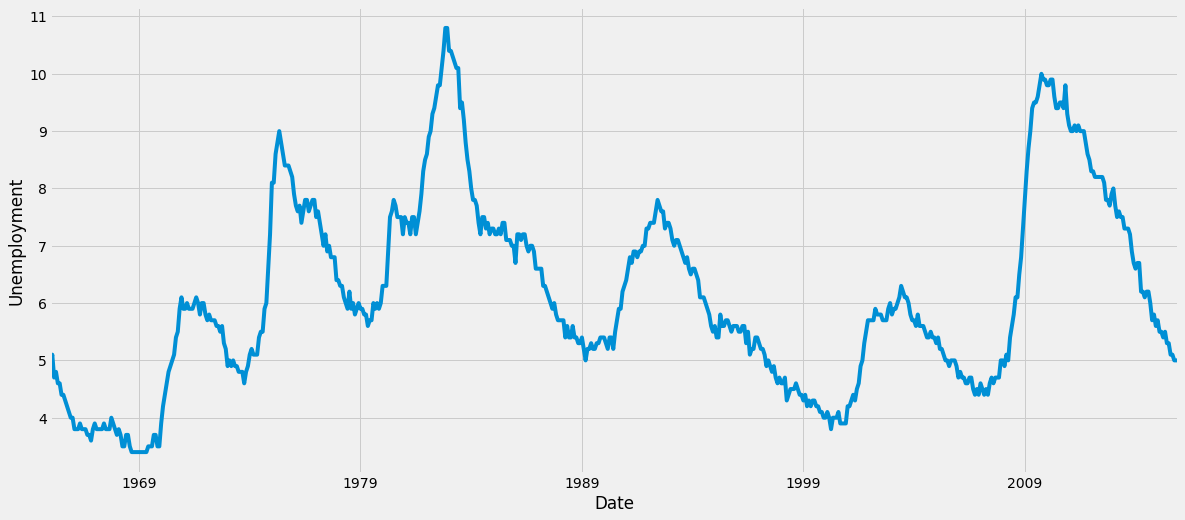

In [0]:
#@title Example: plot the "Inflation" column
"""
Replace "Inflation" by any feature in our data to get other plot. 
"""
plot_column(df, "Unemployment")

### Data Analysis
As a high level overview, some distinguishable patterns appear when we plot the data:
- $\textbf{In the 80's (1979-1989), all features experienced some drastic changes}$. 
- The time-series has $\textbf{seasonality pattern}$, for example, $\textbf{Unemployment}$ has $\textbf{long-term periodicity}$: every 10 years, it goes through 1 or 2 major up and downs. We will examine the seasonality more carefully in the time series analysis section.




## $\textbf{Part I.2 Correlation analysis}$

Though it's indicated that there's no obvious correlation among the 6 features, we compute several different correlations ($\textbf{Naive correlation, Pearson correlation, local Pearson correlation, instantaneous phase synchronization}$) and related statistics in order to

- Test the validity of the assumption (i.e. no two features are apprantly correlated).
- Chose source and target features for later model builds.

By doing so, we can get more understanding about the 'quality' and 'inner relations' of the data. If a feature (e.g. "InterestRate") has no explanatory power to the feature that we want to predict (e.g. "Inflation"), then there is no need for us to use it in the training of our deep learning models. On the other hand, if one feature has higher-than-random correlations to another feature, then it's good to use one of them as the feature and the other as the target. In this case, $\textbf{to determine which feature leads, and which feature follows}$, we check the $\textbf{Dynamic time wrapping}$.


### Code and Examples

In [0]:
#@title ```correlation.py```

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

#matplotlib.rcParams['axes.labelsize'] = 14
#matplotlib.rcParams['xtick.labelsize'] = 12
#matplotlib.rcParams['ytick.labelsize'] = 12
#matplotlib.rcParams['text.color'] = 'k'

from pylab import rcParams
rcParams['figure.figsize'] = 18, 8


import statsmodels.api as sm
import warnings
import itertools
warnings.filterwarnings("ignore")


import seaborn as sns
import scipy.stats as stats
from scipy.signal import hilbert, butter, filtfilt
from scipy.fftpack import fft,fftfreq,rfft,irfft,ifft

# For the dynamic_time_warping function
!pip install dtw
from dtw import dtw, accelerated_dtw


def pearson(df, feature1, feature2):
    """Compute and plot the overall pearson correlation of feature1 and feature2, 
    e.g. pearson(df, "Inflation", "Wage") compute and plot the overall pearson correlation between the "Inflation" and the "Wage" columns

    :param: df, pandas.DataFrame, data contains different features (columns)
    :param: feature1, str, name of the column, e.g. "Inflation"
    :param: feature2, str, name of another column e.g. "Wage"
    """
    overall_pearson_r = df.corr()[feature1][feature2]
    print(f"Pandas computed Pearson r: {overall_pearson_r}")
    # out: Pandas computed Pearson r: 0.2058774513561943
    
    r, p = stats.pearsonr(df.dropna()[feature1], df.dropna()[feature2])
    print(f"Scipy computed Pearson r: {r} and p-value: {p}")
    # out: Scipy computed Pearson r: 0.20587745135619354 and p-value: 3.7902989479463397e-51
     
    #Compute rolling window synchrony
    f,ax=plt.subplots(figsize=(14,3))
    df[[feature1, feature2]].rolling(window=30,center=True).median().plot(ax=ax)
    ax.set(xlabel='Time',ylabel='Pearson r')
    ax.set(title=f"Overall Pearson r = {np.round(overall_pearson_r,2)}")


def local_pearson(df, feature1, feature2):
    """Compute and plot the local pearson correlation of feature1 and feature2, 
    e.g. local_pearson(df, "Inflation", "Wage") compute and plot the local pearson correlation between the "Inflation" and the "Wage" columns

    :param: df, pandas.DataFrame, data contains different features (columns)
    :param: feature1, str, name of the column, e.g. "Inflation"
    :param: feature2, str, name of another column e.g. "Wage"

    """
    # Set window size to compute moving window synchrony.
    r_window_size = 120
    # Interpolate missing data.
    df_interpolated = df[[feature1, feature2]].interpolate()
    # Compute rolling window synchrony
    rolling_r = df_interpolated[feature1].rolling(window=r_window_size, center=True).corr(df_interpolated[feature2])
    f,ax=plt.subplots(2,1,figsize=(14,6),sharex=True)
    df[[feature1, feature2]].rolling(window=30,center=True).median().plot(ax=ax[0])
    ax[0].set(xlabel='Frame',ylabel='Smiling Evidence')
    rolling_r.plot(ax=ax[1])
    ax[1].set(xlabel='Frame',ylabel='Pearson r')
    plt.suptitle("Smiling data and rolling window correlation")


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def instant_phase_sync(df, feature1, feature2):
    """Compute and plot the instantaneous phase synchrony of feature1 and feature2, 
    e.g. instant_phase_sync(df, "Inflation", "Wage") compute and plot the instantaneous phase synchrony between the "Inflation" and the "Wage" columns

    :param: df, pandas.DataFrame, data contains different features (columns)
    :param: feature1, str, name of the column, e.g. "Inflation"
    :param: feature2, str, name of another column e.g. "Wage"
    """
    lowcut  = .01
    highcut = .5
    fs = 30.
    order = 1
    d1 = df[feature1].interpolate().values
    d2 = df[feature2].interpolate().values
    y1 = butter_bandpass_filter(d1,lowcut=lowcut,highcut=highcut,fs=fs,order=order)
    y2 = butter_bandpass_filter(d2,lowcut=lowcut,highcut=highcut,fs=fs,order=order)
    
    al1 = np.angle(hilbert(y1),deg=False)
    al2 = np.angle(hilbert(y2),deg=False)
    phase_synchrony = 1-np.sin(np.abs(al1-al2)/2)
    N = len(al1)

    # Plot results
    f,ax = plt.subplots(3,1,figsize=(14,7),sharex=True)
    ax[0].plot(y1,color='r',label='y1')
    ax[0].plot(y2,color='b',label='y2')
    ax[0].legend(bbox_to_anchor=(0., 1.02, 1., .102),ncol=2)
    ax[0].set(xlim=[0,N], title='Filtered Timeseries Data')
    ax[1].plot(al1,color='r')
    ax[1].plot(al2,color='b')
    ax[1].set(ylabel='Angle',title='Angle at each Timepoint',xlim=[0,N])
    phase_synchrony = 1-np.sin(np.abs(al1-al2)/2)
    ax[2].plot(phase_synchrony)
    ax[2].set(ylim=[0,1.1],xlim=[0,N],title='Instantaneous Phase Synchrony',xlabel='Time',ylabel='Phase Synchrony')
    plt.tight_layout()
    plt.show()



def dynamic_time_warping(df, feature1, feature2):
    """Compute and plot dynamic time warping of feature1 and feature2, 
    e.g. instant_phase_sync(df, "Inflation", "Wage") compute and plot the dynamic_time_wraping between the "Inflation" and the "Wage" columns

    :param: df, pandas.DataFrame, data contains different features (columns)
    :param: feature1, str, name of the column, e.g. "Inflation"
    :param: feature2, str, name of another column e.g. "Wage"
    """
    d1 = df[feature1].interpolate().values
    d2 = df[feature2].interpolate().values
    d, cost_matrix, acc_cost_matrix, path = accelerated_dtw(d1,d2, dist='euclidean')


    plt.imshow(acc_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
    plt.plot(path[0], path[1], 'w')
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.title(f'DTW Minimum Path with minimum distance: {np.round(d,2)}')
    plt.show()

In [0]:
#@title Example: Naive correlation.

df.corr()

,Inflation,Wage,Unemployment,Consumption,Investment,InterestRate
Inflation,1.000000,0.778155,0.191886,0.617820,-0.341421,0.773616
Wage,0.778155,1.000000,-0.068529,0.703745,-0.125412,0.647482
Unemployment,0.191886,-0.068529,1.000000,-0.097183,-0.038286,-0.027809
Consumption,0.617820,0.703745,-0.097183,1.000000,0.203165,0.655305
Investment,-0.341421,-0.125412,-0.038286,0.203165,1.000000,-0.234573
InterestRate,0.773616,0.647482,-0.027809,0.655305,-0.234573,1.000000


Pandas computed Pearson r: 0.7781551675438367
Scipy computed Pearson r: 0.7781551675438365 and p-value: 2.53137614903759e-125


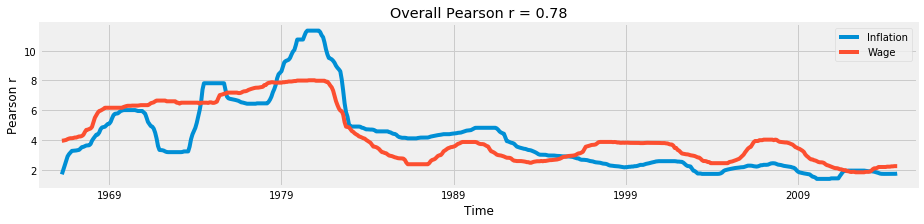

In [0]:
#@title Example: Pearson correlation
pearson(df, "Inflation", "Wage")

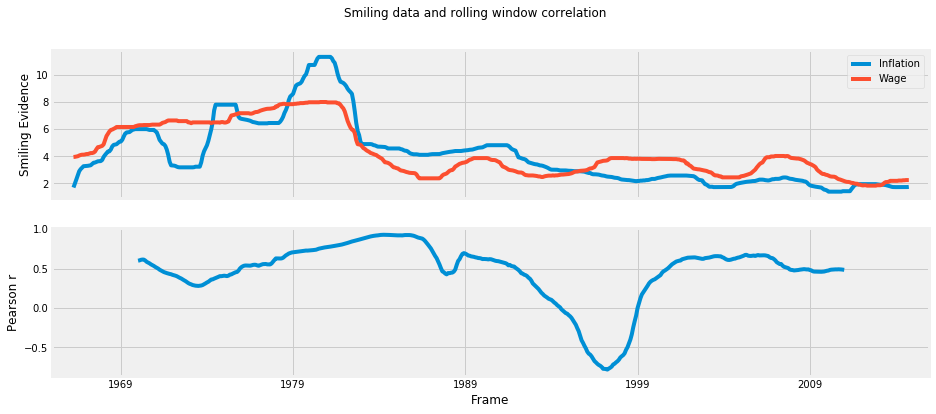

In [0]:
#@title Example: local Pearson correlation
local_pearson(df, "Inflation", "Wage")

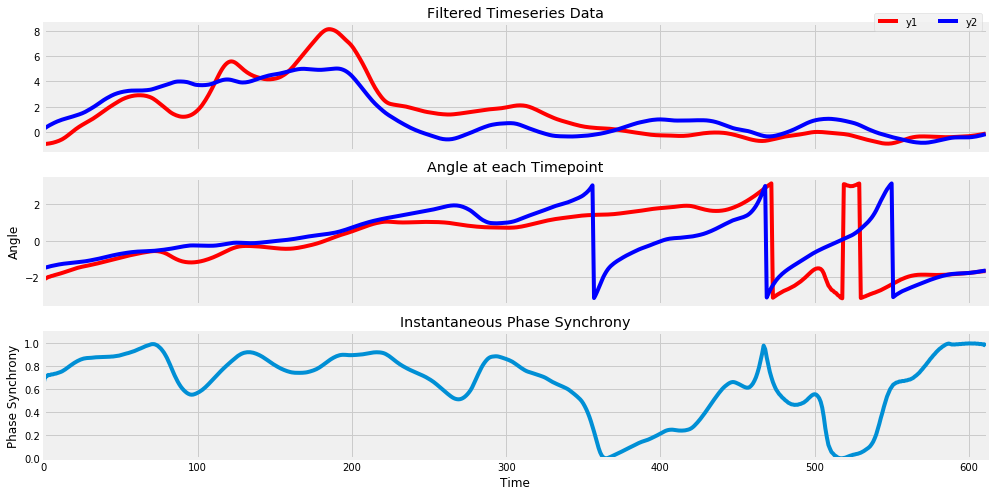

In [0]:
#@title Example: instantaneous phase synchronization
instant_phase_sync(df, "Inflation", "Wage")

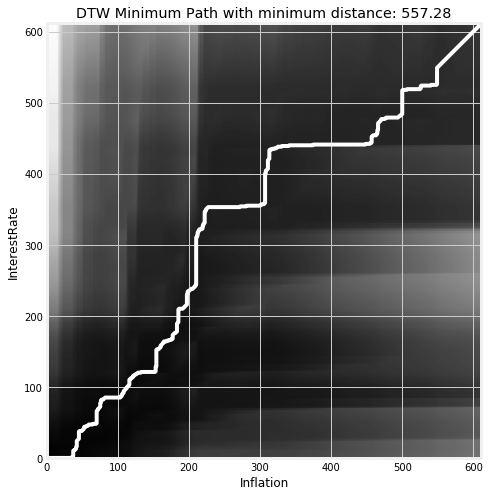

In [0]:
#@title Example: dynamic time wraping
dynamic_time_warping(df, "Inflation", "InterestRate")

### Data analysis

Inspecting the correlations from different angles, we find

- $\textbf{Inflation and Wage have the highest correlation, 0.778155,}$ among all the pairs. 
- Inflation, Wage, Consumption and IntestRate show quite high positive correlation, and low negative correlation to the other two features: Unemployment and Investment.

- $\textbf{Most features slightly leads the Inflation feature}$. 

- For the first 30 years, certain feature pairs show $\textbf{high instantaneous phase synchronization}$, e.g. Inflation and Wage.

We conclude that
- $\textbf{The assumption that no two features have apparent correlation is wrong}$.
- It's reasonable to $\textbf{use Inflation as target and the other 5 features as source for forcasting by the dynamic time wraping analysis}$. 

## $\textbf{Part I.3 Time series analysis with ARIMA}$

As we mentioned above, some remarkable patterns (e.g. seasonality pattern) naturally appear in our data. To understand these patterns better,

- We visualize our data using $\textbf{time-series decomposition}$ that allows us to decompose our time series into three main components: trend, seasonality, and noise.
- We  $\textbf{train an ARIMA (Autoregressive Integrated Moving Average) model}$ to predict and forcast the future Inflation values. To get optimal output, we first
- Use $\textbf{grid search}$ to get the optimal parameters for the ARIMA mode.
- We use $\textbf{ARIMA diagnostics}$ to investigate any unusual behavior.

### Code and examples

In [0]:
#@title ```time_series.py```


def plot_column(df, feature):
    """Plot the resampled column of df, e.g. plot_column(df, "Inflation") plots the "Inflation" column
    
    :param: df, pandas.DataFrame, the data, e.g. df = pd.read_excel("USMacroData", "All")
    :param: feature, str, name of column to be plotted. 
    """
    y = df[feature].resample('MS').mean()
    y.plot(figsize=(15, 6))
    plt.show()


def plot_component(df, feature):
    """Decompose the time series data into trend, seasonal, and residual components.
    
    :param: df, pd.DataFram.
    :param: feature, str,column name/feature name we want to decompose
    :rtype: None
    """
    decomposition = sm.tsa.seasonal_decompose(df[feature].resample("MS").mean(), model='additive')
    fig = decomposition.plot()
    plt.show()






###### This section uses ARIMA to analyze the data and make predictions.########################################

# Grid search to find the best ARIMA parameters 
def arima_parameters(df, feature, search_range=2):
    """Grid search for the optimal parameters of the Arima model for given data (df) and feature.
    :param: df, pdf.DataFrame, data
    :param: feature, str, feature name.
    :param: search_range, int, the range for the search of the parameters, the default value is 2
    """
    p = d = q = range(0, search_range)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    
    minimal_aic = 0
    optimal_param =[]
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(df[feature].resample('MS').mean(),order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
                results = mod.fit()
                print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
                if results.aic < minimal_aic:
                    optimal_param = [param, param_seasonal]
                    minimal_aic = results.aic
                    print(minimal_aic)
            except:
                continue
    print('\n Optimal parameters ARIMA{}x{}12 - Minimal AIC:{}'.format(optimal_param[0], optimal_param[1], minimal_aic))
    return optimal_param[0], optimal_param[1]



def arima_train(df, feature):
    """Train the arima model with the optimal parameters computed for df and feature.
    """
    order, seasonal_order =  arima_parameters(df, feature)
    mod = sm.tsa.statespace.SARIMAX(df[feature].resample('MS').mean(),
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
    results = mod.fit()
    return results

def arima_diagonostics(results):
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()

def arima_table(results):
    print(results.summary().tables[1])

def arima_predict(results, df, feature, init_date = "2009-01-01", start_date = "2012-01-01"): 
    pred = results.get_prediction(start=pd.to_datetime(start_date), dynamic=False)
    pred_ci = pred.conf_int()
    y = df[feature].resample("MS").mean() 
    ax = y[init_date:].plot(label='observed')
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('Date')
    ax.set_ylabel(feature)
    plt.legend()
    plt.show()
    y_forecasted = pred.predicted_mean
    y_truth = y['2012-01-01':]
    mse = ((y_forecasted - y_truth) ** 2).mean()
    print('The Mean Squared Error of our forecasts is {}\n'.format(round(mse, 20)))
    print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))    


def arima_forcast(results, df, feature):
    pred_uc = results.get_forecast(steps=100)
    pred_ci = pred_uc.conf_int()
    y = df[feature].resample("MS").mean() 
    ax = y.plot(label='observed', figsize=(14, 7))
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(feature)
    plt.legend()
    plt.show()



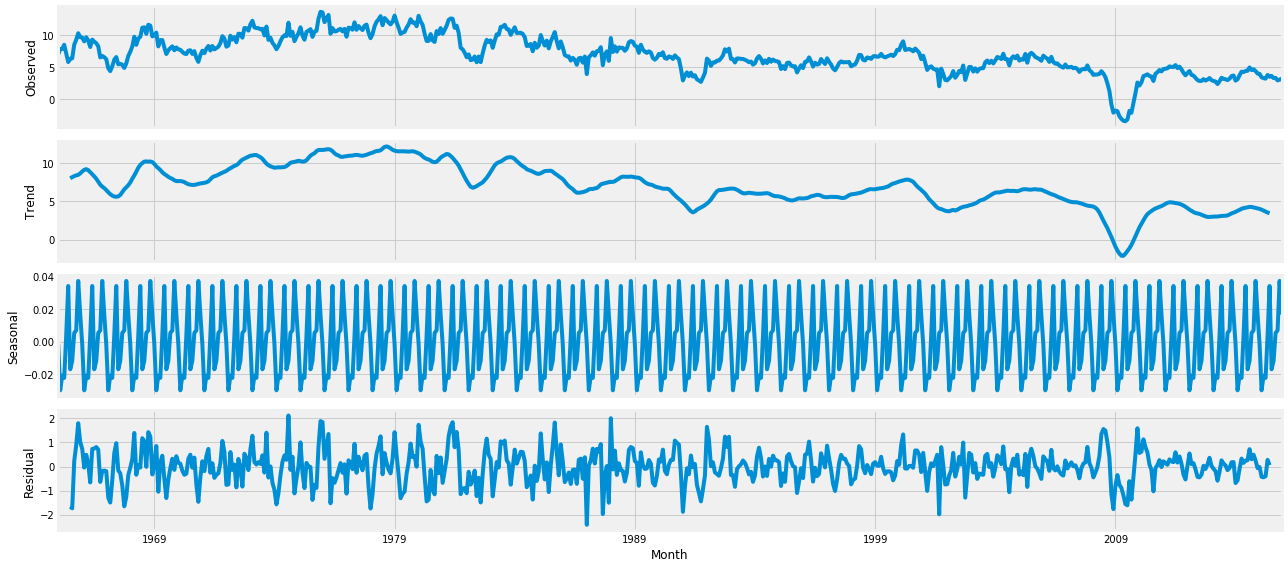

In [0]:
#@title Example: decompose "Consumption" column into trend, seasonal and residual signals

# replace "Consumption" with any feature in our data to get more plots.

plot_component(df, "Consumption")

### Time series analysis with ```ARIMA```



In [0]:
#@title Grid search for optimal ```ARIMA``` parameters

# We find the optimal parameters for "Inflation": ARIMA(1, 1, 1)x(0, 0, 1, 12)
arima_parameters(df, "Inflation")

In [0]:
#@title ```ARIMA``` training

results = arima_train(df, "Inflation")

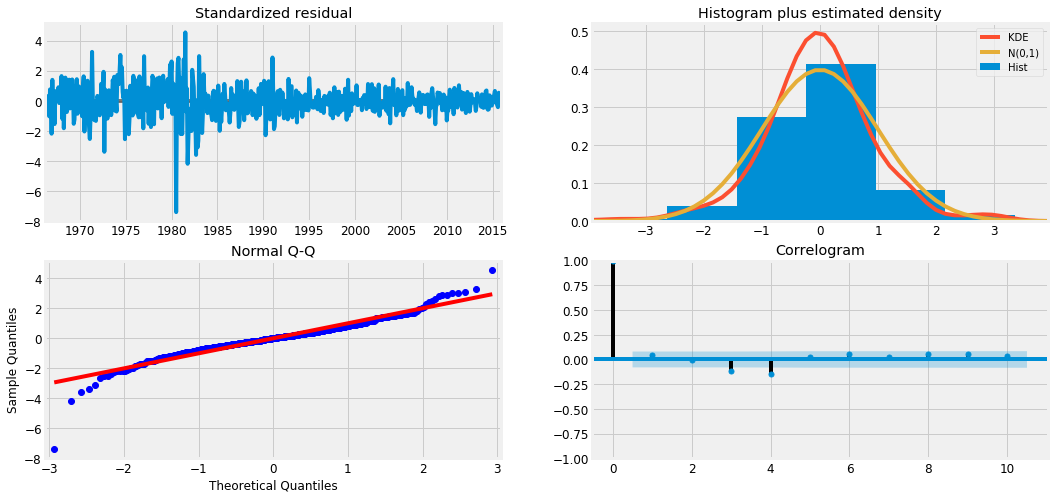

In [0]:
#@title ```ARIMA``` diadonostics
arima_diagonostics(results)

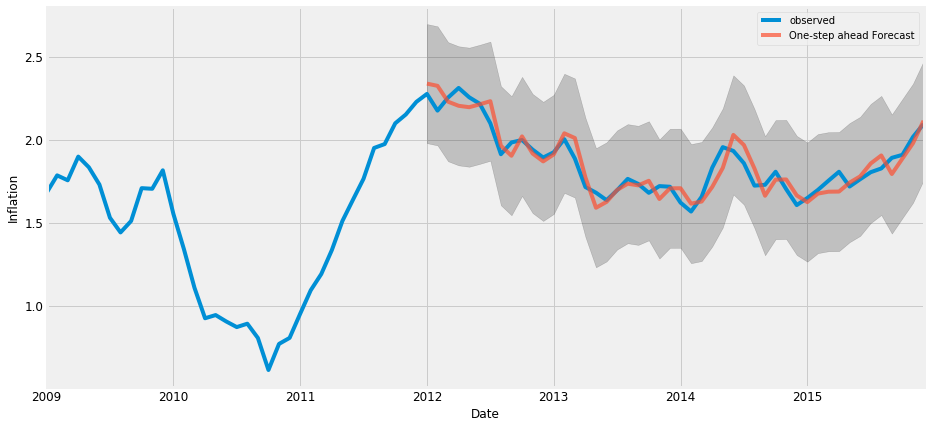

The Mean Squared Error of our forecasts is 0.004963826636415743

The Root Mean Squared Error of our forecasts is 0.07


In [0]:
#@title ```ARIMA``` predictions
arima_predict(results, df, "Inflation")

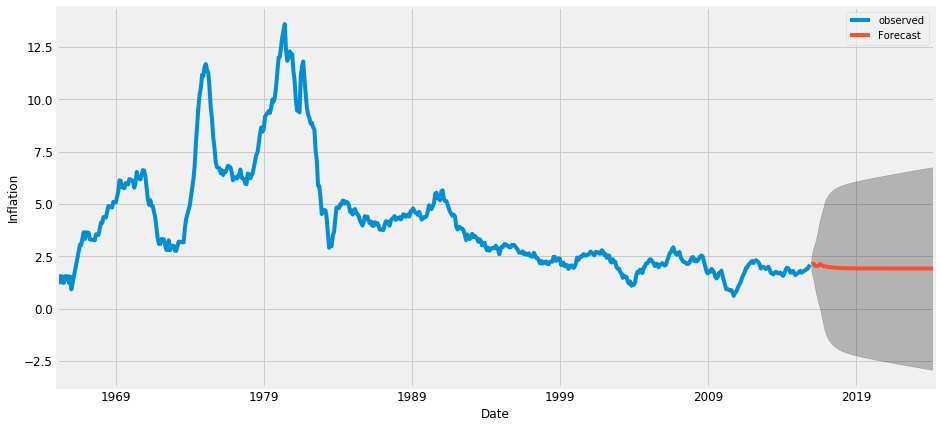

In [0]:
#@title ```ARIMA``` forcasts
arima_forcast(results, df, "Inflation")

### Data Analysis

- Components plot show the obvious seasonality, for example, in every 10 years, the "$\textbf{Inflation}$" feature has 18-20 peaks, which indicates a $\textbf{half-year seasonality}$.

- The optimal ARIMA parameters for "Inflation" are ```(1, 1, 1)x(0, 0, 1, 12)```
- The ARIMA diagonostics show that the $\textbf{noise distribution is narrower  than the normal distribution}$.
- $\textbf{The one-step ahead forcast captures the overall trend well}$.
-  As we forecast further out into the future, we becomes less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.

## $\textbf{Part II.1 Basic model: single-step, single-feature forecasting with LSTM}$ 

$\textbf{Recurrent Neural Networks (RNNs)}$ are good fits for time-series analysis because RNNs keep record of historic data and they're designed to capture patterns developing through time.

However, vanilla RNNs have a major disadvantage---the vanishing gradient problem---"the changes the weights receive during training become so small, making the network unable to converge to a optimal solution. 

$\textbf{LSTM (Long-Short Term Memory)}$ is a variation of vanilla RNNS,it overcomes the vanishing gradiant (or gradiant explode) problem by clipping gradients if they exceed some constant bounds.

In this section, we will
- Process the data to fit the LSTM model
- $\textbf{Build and train the LSTM model for single-step, single-feature prediction}$ (e.g. we predict one feature's tomorrow value with only today's values of the other 5 features). 

In [0]:
#@title imports
import math
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [0]:
#@title Data preparation

def transform_data(df, features, targets, look_back = 0, look_forward = 1, split_ratio = 0.7):
  """transform the data in a custom form.

  :param: df, pd.DataFram, the data, 
    e.g. df = pd.read_excel("USMacroData.xls", "All")
  :param: features, list of strs, the features to be uses as the source features,
     e.g. ["Wage", "Consumption"]
  :param: look_back, int, number of days to look back in historic data,
     e.g. look_back = 11 means we use the last (11+1)=12 months' data to predict the future
  :param:look_forward, int, num of days to look forward
    e.g. look_forward = 3 means we want to predict next 3 months' data
  :param: split_ratio, float, split the data into training dataset and testing dataset by this ratio
    e.g. split_ratio=0.7 means we use the first 70% of the data as training data, the last 30% as the testing dataset
  :rtype: np.arrays, x_train, y_train, x_test, y_test
  """
  x, y = [], []
  for i in range(look_back, len(df) - look_forward):
      assert look_back < len(df)-look_forward, "Invalid look_back, look_forward values"
      
      x.append(np.array(df[i-look_back : i+1][features]))
      y.append(np.array(df[i+1: i+look_forward+1][targets]).transpose())

  # List to np.arrary
  x_arr = np.array(x)
  y_arr = np.array(y)

  split_point = int(len(x)*split_ratio)

  return x_arr[0:split_point], y_arr[0:split_point], x_arr[split_point:], y_arr[split_point:]

features = ["Wage", "Unemployment", "Consumption", "Investment", "InterestRate"]
targets = ["Inflation"]
x_train, y_train, x_test, y_test = transform_data(df, features=features, targets = targets, look_back = 0, look_forward=1, split_ratio=0.7)

#Note that all returned np.arrays are three dimensional.
#Need to reshape y_train and y_test to fit the LSTM

# For the basic model only
y_train = np.reshape(y_train, (y_train.shape[0], -1))
y_test = np.reshape(y_test, (y_test.shape[0], -1))

In [0]:
#@title Build and train the LSTM model

# To match the Input shape (1,5) and our x_train shape is very important. 

def train_model(Optimizer, x_train, y_train, x_test, y_test):
  model = Sequential()
  model.add(LSTM(50, input_shape=(1, 5)))
  model.add(Dense(1))

  model.compile(loss="mean_squared_error", optimizer=Optimizer, metrics =["accuracy"])
  scores = model.fit(x=x_train,y=y_train, batch_size=1, epochs = 100, validation_data = (x_test, y_test))

  return scores, model


In [0]:
#@title Make sure data forms are correct
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(427, 1, 5)
(427, 1)
(184, 1, 5)
(184, 1)


In [0]:
#@title LSTM with SGD, RMSprop, Adam optimizers, epochs = 100
#SGD_score, SGD_model = train_model(Optimizer = "sgd", x_train=x_train, y_train = y_train, x_test =x_test, y_test=y_test)
RMSprop_score, RMSprop_model = train_model(Optimizer = "RMSprop", x_train=x_train, y_train = y_train, x_test =x_test, y_test=y_test)
#Adam_score, Adam_model = train_model(Optimizer = "adam", x_train=x_train, y_train = y_train, x_test =x_test, y_test=y_test)





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 427 samples, validate on 184 samples
Epoch 1/100





427/427 [==============================] - 2s 6ms/step - loss: 6.8603 - acc: 0.0000e+00 - val_loss: 0.9217 - val_acc: 0.0000e+00
Epoch 2/100
427/427 [==============================] - 1s 3ms/step - loss: 2.4877 - acc: 0.0000e+00 - val_loss: 0.7650 - val_acc: 0.0000e+00
Epoch 3/100
427/427 [==============================] - 1s 3ms/step - loss: 1.8379 - acc: 0.0000e+00 - val_loss: 0.7644 - val_acc: 0.0000e+00
Epoch 4/100
427/427 [==============================] - 1s 3ms/step - loss: 1.4932 - acc: 0.0000e+00 - val_loss: 0.7107 - val_acc: 0.0000e+00
Epoch 5/100
427/427 [==============================] - 1s 3ms/step - loss: 1.2980 - acc: 0.0000e+00 - val_loss: 1.0815 - val_acc: 0.0000e+00
Epoch 6/100
427/427 [==============================] - 1s 3ms/step - loss: 1.2265 - acc: 0.0000e+00 - val_loss: 0.8993 - val_acc: 0.0000e+00
Ep

In [0]:
#@title Plot result

def plot_result(score, optimizer_name, label = "loss"):
  plt.figure(figsize=(18, 8))
  plt.plot(range(1, 101), score.history["loss"], label ="Training Loss")
  plt.plot(range(1,101), score.history["val_loss"], label="Validation Loss")
  plt.axis([1,100, 0, 7])
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Train and Validation Loss using "+optimizer_name + "optimizer")
  plt.legend()
  plt.show()


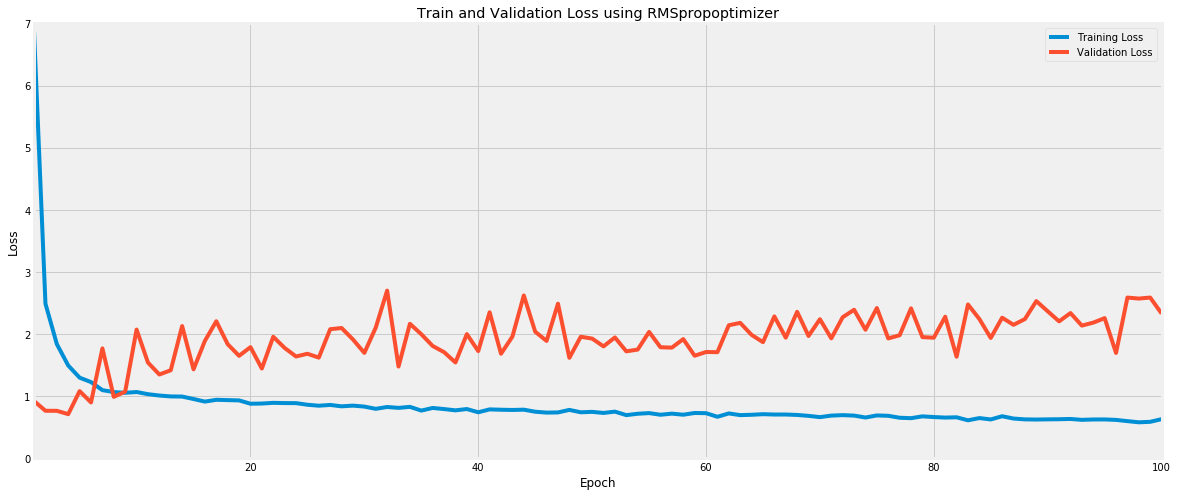

In [0]:
#@title Plot result
plot_result(RMSprop_score, "RMSprop")

In [0]:
#@title Plot predictions
def plot_predict(model, x_train, x_test, y_train, y_test):
  train_predict = RMSprop_model.predict(x_train)
  test_predict = RMSprop_model.predict(x_test)

  # Calculate root mean squared error.
  trainScore = math.sqrt(mean_squared_error(y_train, train_predict))
  print('Train Score: %.2f RMSE' % (trainScore))
  testScore = math.sqrt(mean_squared_error(y_test, test_predict))
  print('Test Score: %.2f RMSE' % (testScore))

  plt.figure(figsize=(18, 8))
  plt.plot(train_predict)
  plt.plot(y_train)
  plt.show()
  
  plt.figure(figsize=(18, 8))
  plt.plot(test_predict)
  plt.plot(y_test)
  plt.show()


Train Score: 0.71 RMSE
Test Score: 1.53 RMSE


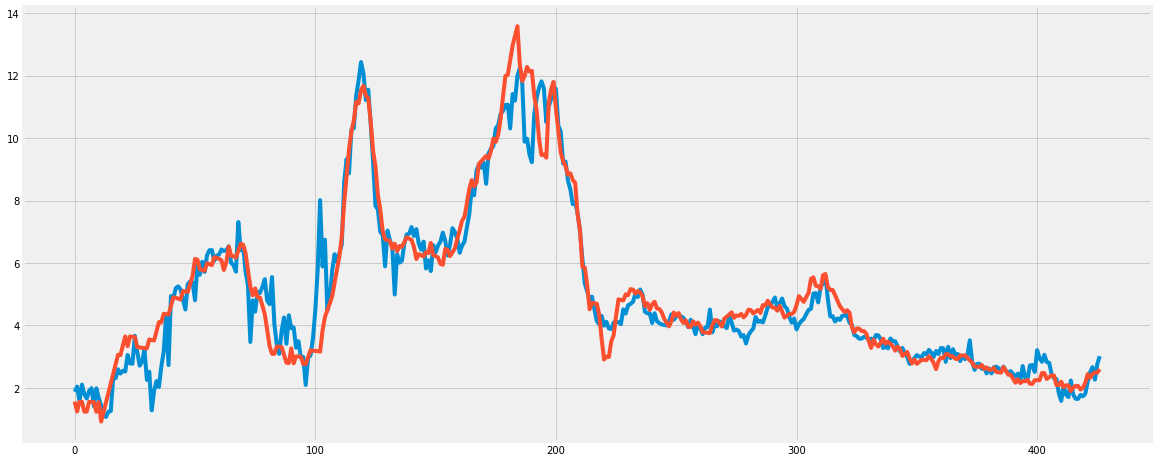

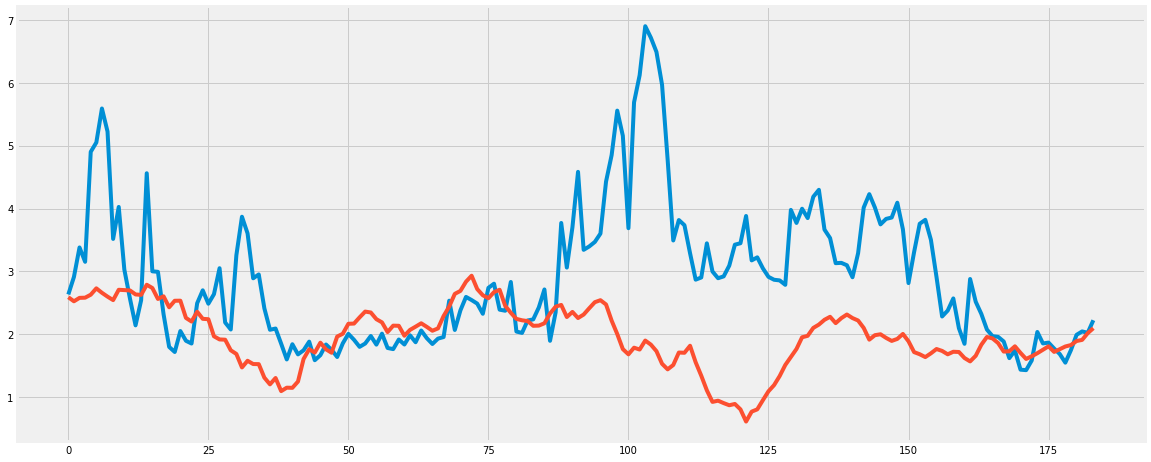

In [0]:
#@title Plot predictions
plot_predict(RMSprop_model, x_train = x_train, y_train=y_train, x_test = x_test, y_test=y_test)

### Data Analysis

We only trained the model for 100 epochs, feel free to modify it to any number as long as we have enough computing power. Here are some results we find during the experiments

- LSTM with Adam or RMSprop optimizers work better than the SGD optimizer in this project.
- Each model fits the training dataset very well.
- $\textbf{The prediction captures the range and characteristics of the real data}$.
- $\textbf{The model doesn't predict the rapid increasing near the 100th test dataset}$.



## $\textbf{Part II.2 Generalized model: multi-step, multi-feature forcasting with LSTM}$

We build a multi-step, multi-feature LSTM model in this section. That means we can use several-day's data to predict multiple days and multiple features in the future. $\textbf{For example, we can use last 12-month's data of Wage, Consumption, Investment, InterestRate to predict next three-month's values of Inflation and Unemployment}$. In this section, we 

- Process the data to fit the requirements of all possible multi-step, multi-feature prediction task.
- We modify the LSTM model accordingly.
- Plot the 3-month prediction for Inflation and Unemployment with last 12-month's data of Wage, Consumption, Investment, and InterestRate.

In [0]:
#@title Data preparation

def transform_data(df, features, targets, look_back = 0, look_forward = 1, split_ratio = 0.7):
  """transform the data in a custom form.

  :param: df, pd.DataFram, the data, 
    e.g. df = pd.read_excel("USMacroData.xls", "All")
  :param: features, list of strs, the features to be uses as the source features,
     e.g. ["Wage", "Consumption"]
  :param: look_back, int, number of days to look back in historic data,
     e.g. look_back = 11 means we use the last (11+1)=12 months' data to predict the future
  :param:look_forward, int, num of days to look forward
    e.g. look_forward = 3 means we want to predict next 3 months' data
  :param: split_ratio, float, split the data into training dataset and testing dataset by this ratio
    e.g. split_ratio=0.7 means we use the first 70% of the data as training data, the last 30% as the testing dataset
  :rtype: np.arrays, x_train, y_train, x_test, y_test
  """
  x, y = [], []
  for i in range(look_back, len(df) - look_forward):
      assert look_back < len(df)-look_forward, "Invalid look_back, look_forward values"
      
      x.append(np.array(df[i-look_back : i+1][features]))
      y.append(np.array(df[i+1: i+look_forward+1][targets]).transpose())

  # List to np.arrary
  x_arr = np.array(x)
  y_arr = np.array(y)

  split_point = int(len(x)*split_ratio)

  return x_arr[0:split_point], y_arr[0:split_point], x_arr[split_point:], y_arr[split_point:]

features = ["Wage", "Consumption", "Investment", "InterestRate"]
targets = ["Inflation", "Unemployment"]
x_train, y_train, x_test, y_test = transform_data(df, features=features, targets = targets, look_back = 11, look_forward=3, split_ratio=0.7)

#Note that all returned np.arrays are three dimensional.
#Need to reshape y_train and y_test to fit the LSTM

# For the multi-step LSTM model only
y_train = np.reshape(y_train, (y_train.shape[0], -1))
y_test = np.reshape(y_test, (y_test.shape[0], -1))

In [0]:
#@title Make the data forms are all correct
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_train.shape)

(418, 12, 4)
(418, 6)
(180, 12, 4)
(418, 6)


In [0]:
#@title Scaling, vectorize and de_vectorize

def scale(arr, df):
  """Scale the data to range (-1,1) to better fit the LSTM model

  :param: arr, np.array, the array to be scaled
  :param: df, pd.DataFrame, to provide the max and min for us to scale arr
  TODO: maybe we don't need the df parameter?
  """
  global_max = max(df.max())
  global_min = min(df.min())
  arr = -1 + (arr-global_min)*2/(global_max-global_min)
  return arr

def de_scale(arr, df):
  """de Scale the data from range (-1,1) to its original range

  :param: arr, np.array, the array to be scaled
  :param: df, pd.DataFrame, to provide the max and min for us to scale arr
  """
  global_max = max(df.max())
  global_min = min(df.min())
  arr = global_min+(arr+1)*(global_max-global_min)/2
  return arr

def vectorize(y_train):
  """To vectorize an np.array.

  :param: y_train, np.array, the array to be vectorized
  :rtype: np.array, vectorized array.
  """
  return np.reshape(y_train, (y_train.shape[0], -1))

def de_vectorize(y_train, row, col):
  """To de_vectorize an np.array: transfrom from 2-dim np.array to its original form.

  :param: y_train, np.array, the array to be de_vectorized
  :rtype: np.array, de_vectorized array.
  """
  return np.reshape(y_train,(y_train.shape[0], row, col))

In [0]:
#@title Multi-step LSTM model, change the input_shape and Dense layer parameter to fit the train data shape and test data shape.

def train_multi_step_model(Optimizer, x_train, y_train, x_test, y_test):
  model = Sequential()
  model.add(LSTM(50, input_shape=(12, 4)))
  model.add(Dense(6))

  model.compile(loss="mean_squared_error", optimizer=Optimizer, metrics =["accuracy"])
  scores = model.fit(x=x_train,y=y_train, batch_size=1, epochs = 200, validation_data = (x_test, y_test))

  return scores, model


In [0]:
#@title Train the model. Change the optimizer parameter to use other optimizers, e.g. "adams"
RMS_score, RMS_model = train_multi_step_model(Optimizer = "RMSprop", x_train=x_train, y_train = y_train, x_test =x_test, y_test=y_test)

Train on 418 samples, validate on 180 samples
Epoch 1/200
418/418 [==============================] - 5s 12ms/step - loss: 5.9280 - acc: 0.2895 - val_loss: 4.9166 - val_acc: 0.4944
Epoch 2/200
418/418 [==============================] - 5s 11ms/step - loss: 1.9184 - acc: 0.4043 - val_loss: 4.7236 - val_acc: 0.2778
Epoch 3/200
418/418 [==============================] - 4s 11ms/step - loss: 1.4018 - acc: 0.3541 - val_loss: 4.1824 - val_acc: 0.2222
Epoch 4/200
418/418 [==============================] - 4s 11ms/step - loss: 1.1442 - acc: 0.3373 - val_loss: 4.1102 - val_acc: 0.2944
Epoch 5/200
418/418 [==============================] - 4s 11ms/step - loss: 0.9653 - acc: 0.3493 - val_loss: 4.2688 - val_acc: 0.2111
Epoch 6/200
418/418 [==============================] - 4s 10ms/step - loss: 0.8703 - acc: 0.3876 - val_loss: 3.7378 - val_acc: 0.3389
Epoch 7/200
418/418 [==============================] - 4s 11ms/step - loss: 0.7075 - acc: 0.3684 - val_loss: 3.1038 - val_acc: 0.2500
Epoch 8/200
418/

In [0]:
#@title Make predictions with the trained model

train_predict = RMS_model.predict(x_train)
test_predict = RMS_model.predict(x_test)

#test_predict = SGD_model.predict(x_test)
#test_predict = de_scale(test_predict, df)
#y_origin =de_scale(y_test, df)


In [0]:
#@title Plot Multi-step, Multi-feature predictions.
def predict_plot(df, y_predict, targets):
  """ Plot the multi-step, multi-result predictions.

  :param: df, pd.DataFrame, e.g. df = pd.read_excel("USMacroData.xls", "All")
  :param: y_predict, 2-dim np.array, the model-predicted values, in each row, it has look_forward*(number of target features) elements.
          In our example, look_forward = 3, number of target features =2 ("Inflation", "Unemployment").
  :param: targets, list, target features, e.g ["Inflation", "Unemployment"]
  """

  y_predict = de_vectorize(y_predict, 2, 3)
  assert y_predict.shape[1] == len(targets), "Incompatible size of targets and dataset"
  assert df.shape[0] == y_predict.shape[0], "Incompatible original data rows and y_predict rows"
  
  look_forward = y_predict.shape[2]

  for index, target in enumerate(targets):
    plt.figure(figsize=(17, 8))
    plt.plot(df[0:12][target])
    for i in range(len(y_predict)):
      y = list(y_predict[i][index])
      x = list(df.index[i: i+look_forward])
      data = pd.DataFrame(list(zip(x, y)), columns =[df.index.name, target]) 
      data = data.sort_values(df.index.name)
      data.set_index(df.index.name, inplace=True)

      if i < 12:
        plt.plot(df[i: i+look_forward][target])
        plt.plot(data)
        plt.xlabel("Date")
        plt.ylabel(target)
        plt.title("3-month predictions of " + target)
    plt.show()


### To read to graph below

- Each short line segment is a 3-month prediction: start, middle, end point of the line segment means the prediction for the next 1, 2, 3 month's data respectively.
- X axies is the data.
- The long line is the real data.
- We plot the prediction for year 2001, change the parameter as you want to get prediction for any other data.

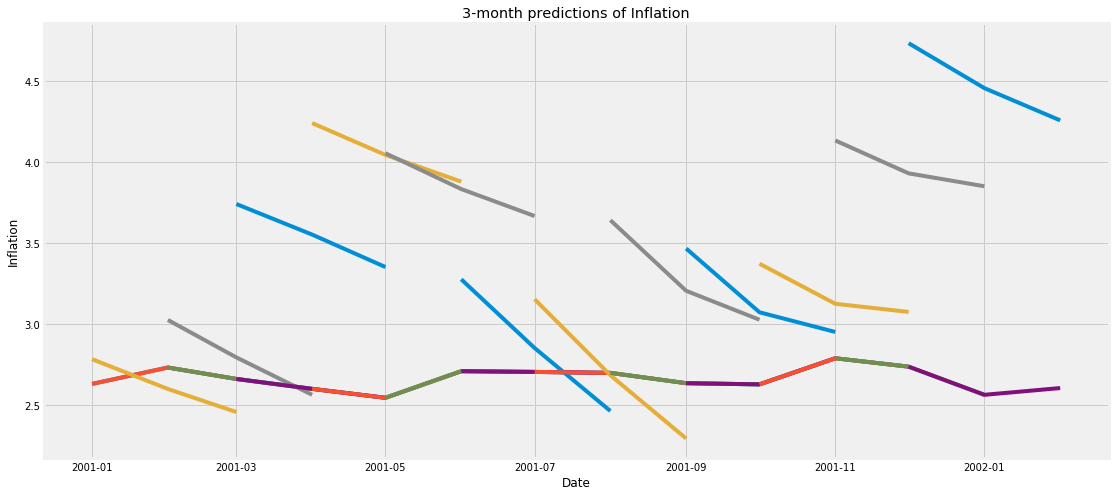

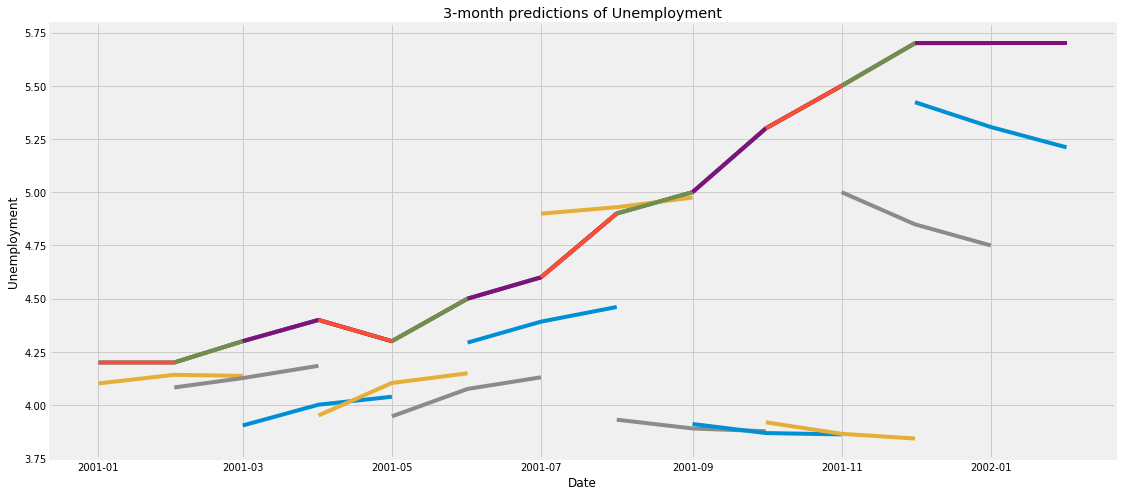

In [0]:
#@title We show the first 12 month's data and corresponding 3-month predictions for all target features
predict_plot(df[432:][["Inflation", "Unemployment"]], test_predict, ["Inflation", "Unemployment"])

### Data Analysis

Though the dataset is not big enough, we still successfully capture several features in the prediction

- $\textbf{Model predictions shows similar trend as the real data}$, e.g. from the predicted Unemployment data above, the predicted values are more or less in the most correct range and goes in the same direction as the real data.
- $\textbf{The model captures the range of the real data very precisely}$.
- $\textbf{All 3-month predictions are continuous}$, which means the modell successfully captures the local behavior of the data.

## $\textbf{Part II.3 Advanced model: Generative Adversarial Network (GAN) with RNN and CNN}$

$\textbf{Generative Adversarial Networks (GAN)}$ have been a successful model in generating realistic images, paintings, and videos. $\textbf{The idea that GANs can to used to predict time-series data is new and experimental}$. We know GANs are powerful in learning characteristics of data, our model is based on the $\textbf{assumptions}$.
- Values of a $\textbf{feature has certain patterns}$ and behavior (characteristics).
- $\textbf{The future values of a feature should follow more or less the same pattern or behavior}$ (unless it starts operating in a totally different way, or the economy drastically changes).

Our $\textbf{goal}$ is that 
- Generate future data that has similar (surely not exactly the same) distribution as the historical data. 

In our model, we use 
- $\textbf{LSTM as a time-series generator}$.
- $\textbf{1-dimensional CNN as a discriminator}$.

In [0]:
#@title imports

import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import LSTM, Conv1D, MaxPool1D, BatchNormalization, Reshape, Flatten


In [0]:
#@title Data preparation

#@title Data preparation

def transform_data(df, features, targets, look_back = 0, look_forward = 1, split_ratio = 0.7):
  """transform the data in a custom form.

  :param: df, pd.DataFram, the data, 
    e.g. df = pd.read_excel("USMacroData.xls", "All")
  :param: features, list of strs, the features to be uses as the source features,
     e.g. ["Wage", "Consumption"]
  :param: look_back, int, number of days to look back in historic data,
     e.g. look_back = 11 means we use the last (11+1)=12 months' data to predict the future
  :param:look_forward, int, num of days to look forward
    e.g. look_forward = 3 means we want to predict next 3 months' data
  :param: split_ratio, float, split the data into training dataset and testing dataset by this ratio
    e.g. split_ratio=0.7 means we use the first 70% of the data as training data, the last 30% as the testing dataset
  :rtype: np.arrays, x_train, y_train, x_test, y_test
  """
  x, y = [], []
  for i in range(look_back, len(df) - look_forward):
      assert look_back < len(df)-look_forward, "Invalid look_back, look_forward values"
      
      x.append(np.array(df[i-look_back : i+1][features]))
      y.append(np.array(df[i+1: i+look_forward+1][targets]).transpose())

  # List to np.arrary
  x_arr = np.array(x)
  y_arr = np.array(y)

  split_point = int(len(x)*split_ratio)

  return x_arr[0:split_point], y_arr[0:split_point], x_arr[split_point:], y_arr[split_point:]

features = ["Wage", "Consumption", "Investment", "InterestRate"]
targets = ["Inflation", "Unemployment"]
x_train, y_train, x_test, y_test = transform_data(df, features=features, targets = targets, look_back = 11, look_forward=3, split_ratio=0.7)

#Note that all returned np.arrays are three dimensional.
#Need to reshape y_train and y_test to fit the LSTM

# For the multi-step LSTM model only
y_train = np.reshape(y_train, (y_train.shape[0], -1))
y_test = np.reshape(y_test, (y_test.shape[0], -1))

In [0]:
#@title Make sure all data forms are as what we want

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(418, 12, 4)
(418, 6)
(180, 12, 4)
(180, 6)


### Model architecture: LSTM generator

It's a 1-layer LSTM model.
- 50 hidden layers of LSTM cells
- 1 dense layer with 6 (2*3) dimensional output, since we have 2 features and 3 months to predict.



In [0]:
#@title Create generator
def create_generator():
  generator = Sequential()
  generator.add(LSTM(50, input_shape=(12,4)))
  generator.add(Dense(6))
  generator.compile(loss="mean_squared_error", optimizer="RMSprop", metrics=["accuracy"])

  return generator

generator = create_generator()
generator.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 50)                11000     
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 306       
Total params: 11,306
Trainable params: 11,306
Non-trainable params: 0
_________________________________________________________________


### Model architecture: CNN discriminator

The structure of the discriminator is given by 
- Reshape layer. Each row in y_train is acturally 1-dimensional (6,), which is different from (6,1)!
- 1-dimensional Convolutional layer with 32, 3$\times$1 filters to capture the characteristics of 3-month real data.
- LeakyReLU layer
- Dropout layer. Random reconfigurate 10% of the weights to zero to prevent overfitting.
- 1-dimensional Convolutional layer with 64, 3$\times$1 filters to capture more characteristics of the real date.
- Batchnormalization layer. To normalize the data.
- 1 Dense layer with 50 hidden nets.
- Dropout layer.
- 1 Dense layer with 1 net. 


In [0]:
#@title Create discriminator
# CNN discriminator, Learn the distribution of the price.
# The goal of the gan model is to study the "characteristics" of, for example, the "Inflation" rate.
# The generator tries to generate "Inflation" data as real as possible based on the other features, e.g "Unempolyment", "Wage", etc.
FILTER_SIZE = 3
NUM_FILTER = 32
INPUT_SIZE = 3 # num of days we want to predict
MAXPOOL_SIZE = 1 # our data set is small, so we don't even need it 
BATCH_SIZE = 1 # our data set is small, we don't need large batch size
STEP_PER_EPOCH = 612//BATCH_SIZE 
EPOCHS = 10


def create_discriminator():
  discriminator = Sequential()
  discriminator.add(Reshape((6,1), input_shape=(6,)))
  discriminator.add(Conv1D(NUM_FILTER, FILTER_SIZE, input_shape = (6,1)))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.1))
  discriminator.add(Conv1D(2*NUM_FILTER, FILTER_SIZE))
  discriminator.add(BatchNormalization())

  discriminator.add(Dense(units=50))
  discriminator.add(Dropout(0.1))
  
  #reduce the dimension of the model to 1
  discriminator.add(Flatten())

  discriminator.add(Dense(units=1, activation="sigmoid"))

  discriminator.compile(loss="mean_squared_error", optimizer="RMSprop")
  return discriminator

discriminator = create_discriminator()
discriminator.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 6, 1)              0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4, 32)             128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 4, 32)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 32)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2, 64)             6208      
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 64)             256       
____

In [0]:
#@title Create a GAN model with LSTM as the generator and CNN as the discriminator
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(12,4))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='mean_squared_error', optimizer='adam')
    return gan
gan = create_gan(discriminator, generator)
gan.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 12, 4)             0         
_________________________________________________________________
sequential_6 (Sequential)    (None, 6)                 11306     
_________________________________________________________________
sequential_7 (Sequential)    (None, 1)                 9943      
Total params: 21,249
Trainable params: 11,306
Non-trainable params: 9,943
_________________________________________________________________


In [0]:
#@title Training function for the entangled GAN model
def training(x_train, y_train, x_test, y_test, epochs=1, random_size=128):
    
    #Loading the data
    random_count = 4*x_train.shape[0] / random_size
    
    # Creating GAN
    generator= create_generator()

    #y_lstm = np.reshape(y_train, (y_train.shape[0],1))
    #scores = generator.fit(x=x_train,y=y_lstm, batch_size=1, epochs = 100, validation_data = (x_test, y_test))
    #plt.plot(generator.predict(x_train))
    #plt.plot(y_lstm)
    #plt.show()


    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)
        for index in tqdm(range(random_size)):
        #generate  random noise as an input  to  initialize the  generator
            feature = x_train[np.random.randint(low=0,high=x_train.shape[0],size=random_size),:]
            
            # Generate fake MNIST images from noised input
            fake_money = generator.predict(feature)
            #print(fake_money)
            #print(fake_money.shape)
            # Get a random set of  real images

            #real_money =y_train[np.random.randint(low=0,high=y_train.shape[0],size=random_size),:]
            upper_bound = int(np.random.randint(low=random_size, high=y_train.shape[0], size=1))

            real_money = y_train[upper_bound-random_size: upper_bound]

            real_money = np.reshape(real_money, (real_money.shape[0],6))
            #print(real_money)
            #print(real_money.shape)
            
            #Construct different batches of  real and fake data 
            combination = np.concatenate([real_money, fake_money])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*random_size)
            y_dis[:random_size]=0.9
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(combination, y_dis)
            
            #Tricking the noised input of the Generator as real data
            trick_feature = x_train[np.random.randint(low=0,high=x_train.shape[0],size=random_size),:]
            y_gen = np.ones(random_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(trick_feature, y_gen)
            
        if e == 1 or e % 20 == 0:
          #plot generator_predict(x_test) and y_test on the same graph
          plt.figure(figsize=(17,8))
          plt.plot(generator.predict(x_train))
          y_plot = np.reshape(y_train, (y_train.shape[0],6))
          plt.plot(y_plot)
          plt.show()

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 1


100%|██████████| 128/128 [00:08<00:00, 15.65it/s]


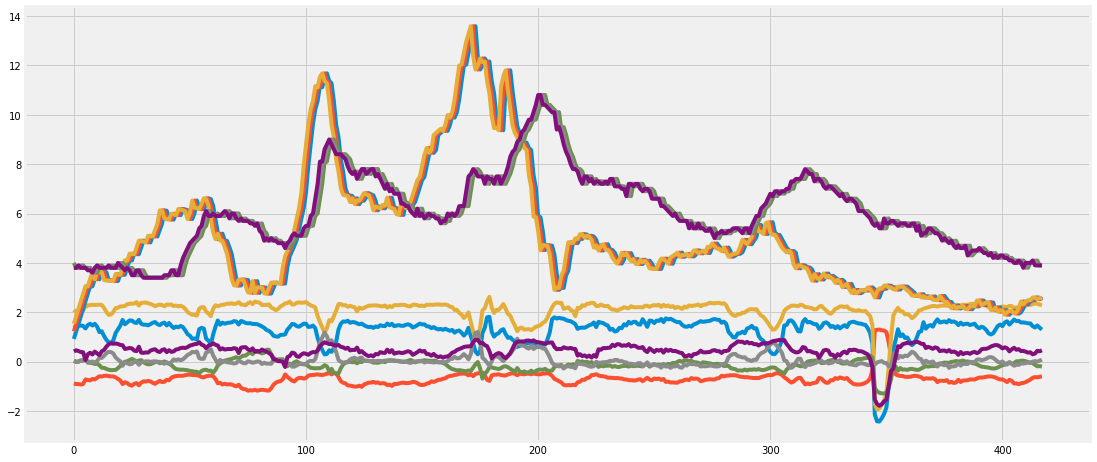

  2%|▏         | 2/128 [00:00<00:06, 19.94it/s]

Epoch 2


  3%|▎         | 4/128 [00:00<00:03, 31.94it/s]

Epoch 3


  2%|▏         | 3/128 [00:00<00:04, 27.07it/s]

Epoch 4


  2%|▏         | 3/128 [00:00<00:04, 28.72it/s]

Epoch 5


  2%|▏         | 3/128 [00:00<00:04, 28.50it/s]

Epoch 6


  3%|▎         | 4/128 [00:00<00:04, 30.87it/s]

Epoch 7


  2%|▏         | 3/128 [00:00<00:04, 29.67it/s]

Epoch 8


  2%|▏         | 3/128 [00:00<00:04, 29.97it/s]

Epoch 9


  3%|▎         | 4/128 [00:00<00:04, 30.65it/s]

Epoch 10


  2%|▏         | 3/128 [00:00<00:04, 29.40it/s]

Epoch 11


  2%|▏         | 3/128 [00:00<00:04, 26.66it/s]

Epoch 12


  3%|▎         | 4/128 [00:00<00:04, 29.75it/s]

Epoch 13


  3%|▎         | 4/128 [00:00<00:04, 30.95it/s]

Epoch 14


  3%|▎         | 4/128 [00:00<00:03, 33.43it/s]

Epoch 15


  2%|▏         | 3/128 [00:00<00:04, 28.34it/s]

Epoch 16


  3%|▎         | 4/128 [00:00<00:03, 33.40it/s]

Epoch 17


  3%|▎         | 4/128 [00:00<00:04, 30.01it/s]

Epoch 18


  3%|▎         | 4/128 [00:00<00:03, 31.46it/s]

Epoch 19


  3%|▎         | 4/128 [00:00<00:03, 34.89it/s]

Epoch 20


100%|██████████| 128/128 [00:04<00:00, 31.69it/s]


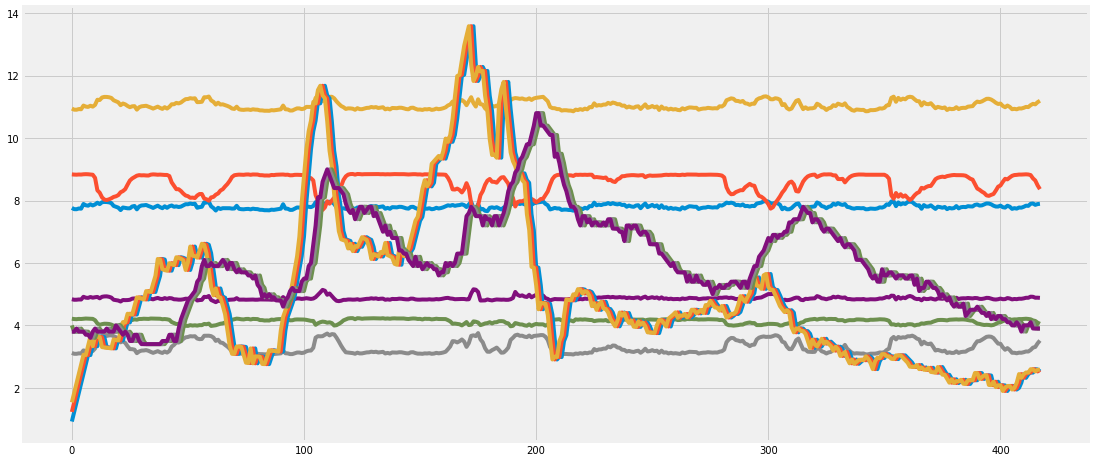

  2%|▏         | 2/128 [00:00<00:06, 19.48it/s]

Epoch 21


  2%|▏         | 3/128 [00:00<00:04, 29.29it/s]

Epoch 22


  2%|▏         | 3/128 [00:00<00:04, 28.60it/s]

Epoch 23


  2%|▏         | 3/128 [00:00<00:04, 29.10it/s]

Epoch 24


  2%|▏         | 3/128 [00:00<00:04, 28.07it/s]

Epoch 25


  2%|▏         | 3/128 [00:00<00:04, 27.76it/s]

Epoch 26


  2%|▏         | 3/128 [00:00<00:04, 26.23it/s]

Epoch 27


  2%|▏         | 3/128 [00:00<00:04, 29.21it/s]

Epoch 28


  3%|▎         | 4/128 [00:00<00:03, 31.93it/s]

Epoch 29


  2%|▏         | 3/128 [00:00<00:04, 29.86it/s]

Epoch 30


  2%|▏         | 3/128 [00:00<00:04, 29.26it/s]

Epoch 31


  2%|▏         | 3/128 [00:00<00:04, 28.09it/s]

Epoch 32


  2%|▏         | 3/128 [00:00<00:04, 29.95it/s]

Epoch 33


  2%|▏         | 3/128 [00:00<00:04, 28.55it/s]

Epoch 34


  2%|▏         | 3/128 [00:00<00:04, 28.76it/s]

Epoch 35


  2%|▏         | 3/128 [00:00<00:04, 28.67it/s]

Epoch 36


  3%|▎         | 4/128 [00:00<00:04, 30.19it/s]

Epoch 37


  3%|▎         | 4/128 [00:00<00:04, 30.92it/s]

Epoch 38


  2%|▏         | 3/128 [00:00<00:04, 28.82it/s]

Epoch 39


  3%|▎         | 4/128 [00:00<00:04, 30.61it/s]

Epoch 40


100%|██████████| 128/128 [00:04<00:00, 29.19it/s]


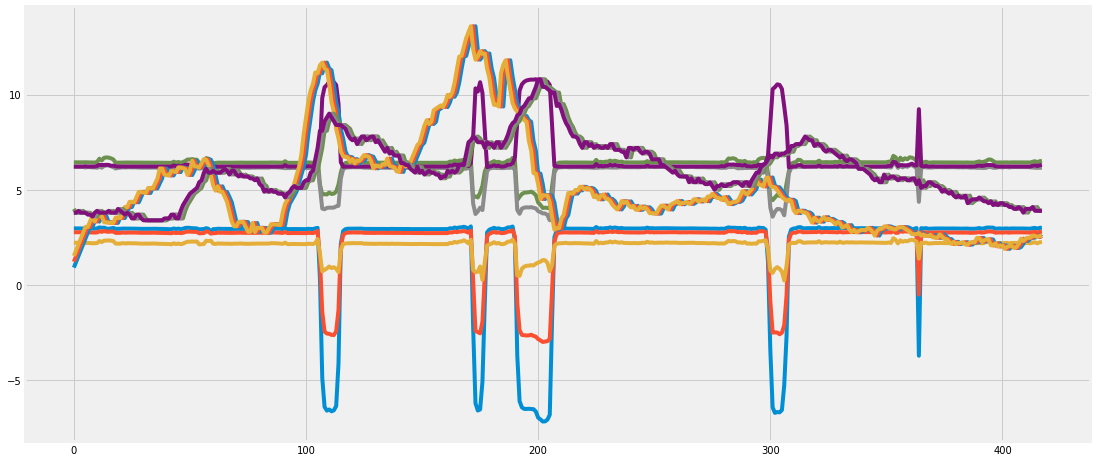

  2%|▏         | 2/128 [00:00<00:06, 19.26it/s]

Epoch 41


  3%|▎         | 4/128 [00:00<00:03, 33.59it/s]

Epoch 42


  3%|▎         | 4/128 [00:00<00:03, 32.75it/s]

Epoch 43


  3%|▎         | 4/128 [00:00<00:03, 32.29it/s]

Epoch 44


  3%|▎         | 4/128 [00:00<00:03, 32.79it/s]

Epoch 45


  3%|▎         | 4/128 [00:00<00:03, 31.92it/s]

Epoch 46


  3%|▎         | 4/128 [00:00<00:04, 30.85it/s]

Epoch 47


  3%|▎         | 4/128 [00:00<00:04, 30.54it/s]

Epoch 48


  3%|▎         | 4/128 [00:00<00:04, 30.64it/s]

Epoch 49


  2%|▏         | 3/128 [00:00<00:04, 29.82it/s]

Epoch 50


  3%|▎         | 4/128 [00:00<00:03, 31.06it/s]

Epoch 51


  2%|▏         | 3/128 [00:00<00:04, 28.80it/s]

Epoch 52


  2%|▏         | 3/128 [00:00<00:04, 28.35it/s]

Epoch 53


  2%|▏         | 3/128 [00:00<00:04, 27.59it/s]

Epoch 54


  2%|▏         | 3/128 [00:00<00:04, 28.65it/s]

Epoch 55


  3%|▎         | 4/128 [00:00<00:03, 31.88it/s]

Epoch 56


  3%|▎         | 4/128 [00:00<00:03, 33.61it/s]

Epoch 57


  3%|▎         | 4/128 [00:00<00:04, 30.45it/s]

Epoch 58


  2%|▏         | 3/128 [00:00<00:04, 27.55it/s]

Epoch 59


  2%|▏         | 3/128 [00:00<00:04, 28.68it/s]

Epoch 60


100%|██████████| 128/128 [00:04<00:00, 29.85it/s]


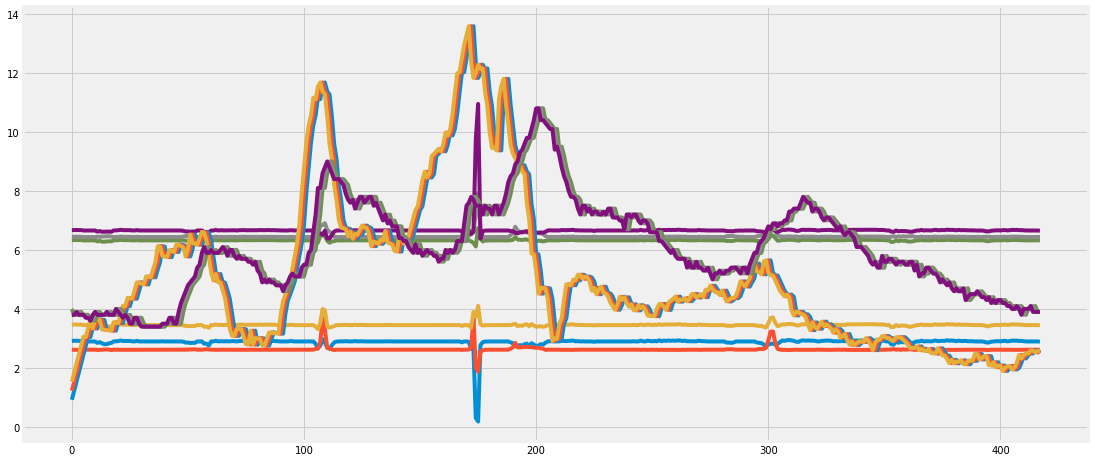

  2%|▏         | 2/128 [00:00<00:06, 19.16it/s]

Epoch 61


  2%|▏         | 3/128 [00:00<00:04, 29.39it/s]

Epoch 62


  2%|▏         | 3/128 [00:00<00:04, 29.60it/s]

Epoch 63


  3%|▎         | 4/128 [00:00<00:03, 31.27it/s]

Epoch 64


  3%|▎         | 4/128 [00:00<00:03, 31.11it/s]

Epoch 65


  2%|▏         | 3/128 [00:00<00:04, 28.81it/s]

Epoch 66


  3%|▎         | 4/128 [00:00<00:03, 32.00it/s]

Epoch 67


  3%|▎         | 4/128 [00:00<00:03, 31.03it/s]

Epoch 68


  2%|▏         | 3/128 [00:00<00:04, 28.40it/s]

Epoch 69


  2%|▏         | 3/128 [00:00<00:04, 28.61it/s]

Epoch 70


  2%|▏         | 3/128 [00:00<00:04, 28.97it/s]

Epoch 71


  2%|▏         | 3/128 [00:00<00:04, 28.25it/s]

Epoch 72


  2%|▏         | 3/128 [00:00<00:04, 28.63it/s]

Epoch 73


  3%|▎         | 4/128 [00:00<00:03, 33.55it/s]

Epoch 74


  3%|▎         | 4/128 [00:00<00:03, 33.34it/s]

Epoch 75


  3%|▎         | 4/128 [00:00<00:04, 30.63it/s]

Epoch 76


  3%|▎         | 4/128 [00:00<00:04, 30.93it/s]

Epoch 77


  3%|▎         | 4/128 [00:00<00:03, 31.83it/s]

Epoch 78


  2%|▏         | 3/128 [00:00<00:04, 28.81it/s]

Epoch 79


  2%|▏         | 3/128 [00:00<00:04, 28.71it/s]

Epoch 80


100%|██████████| 128/128 [00:04<00:00, 28.87it/s]


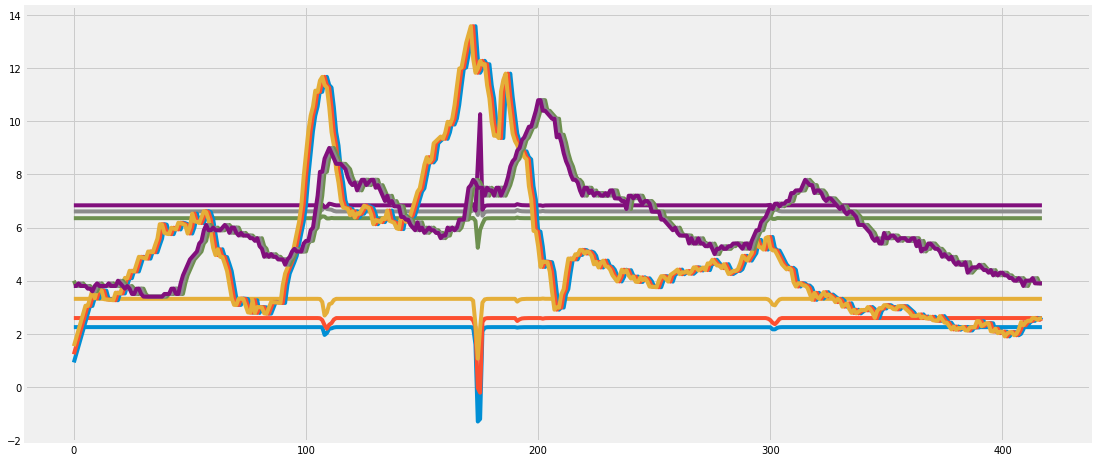

  2%|▏         | 3/128 [00:00<00:05, 24.81it/s]

Epoch 81


  3%|▎         | 4/128 [00:00<00:04, 30.41it/s]

Epoch 82


  2%|▏         | 3/128 [00:00<00:04, 28.14it/s]

Epoch 83


  2%|▏         | 3/128 [00:00<00:04, 27.89it/s]

Epoch 84


  3%|▎         | 4/128 [00:00<00:03, 33.79it/s]

Epoch 85


  2%|▏         | 3/128 [00:00<00:04, 29.43it/s]

Epoch 86


  2%|▏         | 3/128 [00:00<00:04, 29.16it/s]

Epoch 87


  3%|▎         | 4/128 [00:00<00:03, 31.31it/s]

Epoch 88


  3%|▎         | 4/128 [00:00<00:03, 31.11it/s]

Epoch 89


  3%|▎         | 4/128 [00:00<00:04, 30.89it/s]

Epoch 90


  3%|▎         | 4/128 [00:00<00:04, 29.90it/s]

Epoch 91


  3%|▎         | 4/128 [00:00<00:03, 31.57it/s]

Epoch 92


  2%|▏         | 3/128 [00:00<00:04, 29.85it/s]

Epoch 93


  2%|▏         | 3/128 [00:00<00:04, 29.71it/s]

Epoch 94


  3%|▎         | 4/128 [00:00<00:04, 30.58it/s]

Epoch 95


  2%|▏         | 3/128 [00:00<00:04, 27.01it/s]

Epoch 96


  3%|▎         | 4/128 [00:00<00:04, 30.88it/s]

Epoch 97


  3%|▎         | 4/128 [00:00<00:03, 31.04it/s]

Epoch 98


  2%|▏         | 3/128 [00:00<00:04, 29.26it/s]

Epoch 99


  2%|▏         | 3/128 [00:00<00:04, 28.76it/s]

Epoch 100


100%|██████████| 128/128 [00:04<00:00, 30.81it/s]


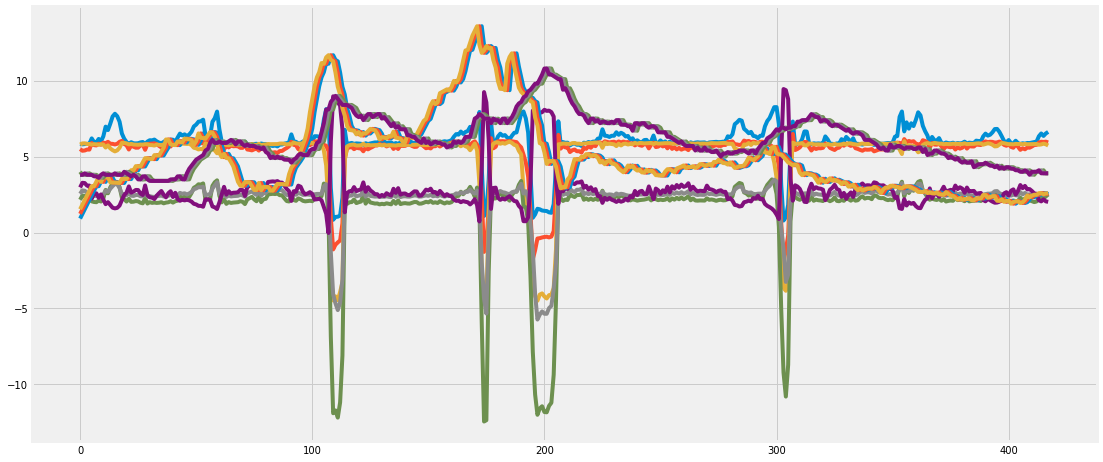

In [0]:
training(x_train, y_train, x_test, y_test, epochs=100, random_size=128)


### Data Analysis

- $\textbf{Our LSTM generator is not pre-trained}$, which means $\textbf{The GAN model learns from scratch}$, though we didn't get results as good as the previous models, but $\textbf{this experimental model shows potentials}$, as we can see 

- The GAN model successfully learned the correct range.
- $\textbf{The GAN model learns the most drastic characteristics of the data}$. Namely, the sudden huge changes. 

## $\textbf{Part III Conclusions and Next steps}$

### Conclusions

In this project on analyzing and forecasting the US macro data we managed to accomplish the following goals:

- $\textbf{Statistical analysis in Part I}$
  - Basic manipulation: read the file, find null values and set index and some column plottings.
  - Correlation analysis: compute different correlations and use to to validate our choice of "Inflation" as the target. 
  - Time series analysis with ```ARIMA```: grid search for optimal parameters and train the ARIMA model for predicting and forcasting.

- $\textbf{Build 3 Deep learning models from basic one to advanced one in Part II.}$
  
  - Basic model: single-step, single-feature forecasting with LSTM
  - Generalized model: multi-step, multi-feature forcasting with LSTM
  - Advanced model: Generative Adversarial Network (GAN) with LSTM and CNN. 

Along the way, we find several remarkable patterns and features of our data

- Features show $\textbf{long-period seasonality}$.

- $\textbf{Several features show apparent correlations}$. 

- $\textbf{Most features slightly leads the Inflation feature}$. 
- The GAN model successfully learned the correct range.
- $\textbf{The GAN model learns the most drastic characteristics of the data}$.

### Next steps

The USMacroData is not a big dataset, the following are a few furthur steps that we have done but not included in the notebook for clarity, or directions we can try to investigate:

- It's natural to $\textbf{include the target feature itself into consideration}$, because in anyway, the historic data of a feature itself is most relevant to the future value of the feature itself. It can be easily achieved by modifying few lines of code.
- Investigate the difference between the first thirty years and the last twenty years.
- $\textbf{Pre-train the LSTM model in the GAN model. In this way, the model can generate predictions at least as good as the first two models and with the CNN discriminator, the LSTM model can also learn the characteristics of the real data, in this way, we can hope to get much better predictions}$.